# Pyomo example notebook

In this notebook, we go through the formulation of a small test network in pyomo.

In [17]:
from os import path
import sys
#sys.path.append(path.dirname(path.dirname(path.abspath(__file__))))

import tensorflow as tf
import numpy as np
import pyomo.environ as pyo

from relumip.ann_model import AnnModel
from relumip.utils.visualization import plot_results_2d

NameError: name '__file__' is not defined

First, we need to load the trained tensorflow model which we want to embed into an optimization problem. Here, a network with 5 layers, 5 neurons each was trained on data generated by the [peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) test function. Our goal will be to find the global minimum of this function by minimizing the output of the  trained ANN.

In [11]:
tf_model = tf.keras.models.load_model('data/peaks_3x10.h5')

Now, we create a pyomo model and a block which will contain the ANN.

In [12]:
model = pyo.ConcreteModel()
model.construct()
model.ann = pyo.Block()

Before generating the ANN formulation, we need to specify the input and output variables of our network. Here, the network input is two-dimensional and the network output is one-dimensional. In order to arrive at a tight optimization formulation of our network, the variable bounds of the network input **have to be defined**. For the *peaks* data set, both input variables have lower bound -3 and upper bound 3. Note that these bounds can not be inferred from the tensorflow model and thus have to be known by the user (the bounds can be computed from the data used to train the ANN, for example). For the output variables, bounds can be defined loosely or not at all.

In [13]:
model.ann.Input1 = pyo.Var(within=pyo.Reals, bounds=(-3, 3))
model.ann.Input2 = pyo.Var(within=pyo.Reals, bounds=(-3, 3))
model.ann.Output = pyo.Var(bounds=(-10000, 10000), within=pyo.Reals)

input_vars = [model.ann.Input1, model.ann.Input2]
output_vars = [model.ann.Output]

A AnnModel instance can be created by specifying the underlying tensorflow model and the desired modeling language. Then, the user-defined ANN input and output variables are linked to the AnnModel. Note that both have to be passed in list form.

In [14]:
ann_model = AnnModel(tf_model=tf_model, modeling_language='PYOMO')

ann_model.connect_network_input(opt_model=model.ann, input_vars=input_vars)
ann_model.connect_network_output(opt_model=model.ann, output_vars=output_vars)

After all the relevant information has been defined, the network formulation can now be created and embedded in the model.ann Block. A pyomo solver object has to be passed to the function as it will be used for progressive bound tightening. There are currently two diffenrent bound tightening options for the pyomo interface: 'MIP' and 'LP'. 'MIP' will produce the optimal bounds for each node in the network, but can be quite time consuming for larger networks. 'LP' solves relaxed sub-problems during bound tightening, which results in weaker bounds but is less time intensive

In [15]:
solver = pyo.SolverFactory('glpk')
ann_model.embed_network_formulation(bound_tightening_strategy='LP', solver=solver)

Evaluating node (4,0): : 21it [00:10,  2.08it/s]                                                                       


The constraints and variables describing the network have now been added to the model. We can continue to build our model using the input and output variables defined above. In this simple example, we don't wish to add any additional constraints or variables, but elect to minimize the output of our ANN. This is equivalent to finding the global optimum of out network function, and thereby also approximating the global optimum of the *peaks* function (the quality of this approximation depends on the quality of the underlying tensorflow model). Thus, we set the objective of out model equal to the output of the embedded ANN and solve.

In [16]:
model.obj = pyo.Objective(expr=model.ann.Output, sense=pyo.minimize)
res = solver.solve(model)

We can display our full pyomo model to get a sense its structure. We see that the ANN nodes are organized as indexed blocks. Each block describing a hidden node contains one variable equivalent to the node output (*x*), and one binary variable indicating wether the node is active or not (*z*). Additionally, each node contains three constraints encoding the ReLU activation function. The constraints are stored in ConstrainLists of the ANN block.

In [17]:
model.display()

Model unknown

  Variables:
    None

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : -7.2141923904418945

  Constraints:
    None

  Blocks:
    Block ann
    
      Variables:
        Input1 : Size=1, Index=None
            Key  : Lower : Value               : Upper : Fixed : Stale : Domain
            None :    -3 : 0.28694861079423695 :     3 : False : False :  Reals
        Input2 : Size=1, Index=None
            Key  : Lower : Value               : Upper : Fixed : Stale : Domain
            None :    -3 : -1.6053862397641538 :     3 : False : False :  Reals
        Output : Size=1, Index=None
            Key  : Lower               : Value               : Upper             : Fixed : Stale : Domain
            None : -7.2141923904418945 : -7.2141923904418945 : 8.580820083618164 : False : False :  Reals
    
      Objectives:
        None
    
      Constraints:
        c1 : Size=28
            Key : Lower : Body         

To visualize the computed solution, we can evaluate the tensorlow model on a set of random points within the domain defined by the ANN input variables. The solution point computed by the above optimization problem is extracted from the model and displayed as a red dot on the plot. Evidently, it is located at the minimum of the network output.

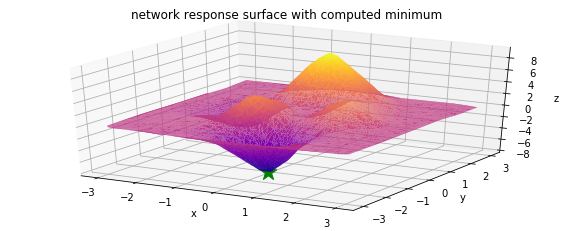

In [18]:
sample_input = 6 * np.random.rand(10000, 2) - 3
sample_output = tf_model.predict(sample_input)
sol_point = [model.ann.Input1.value, model.ann.Input2.value, model.ann.Output.value]
plot_results_2d(sample_input, sample_output, sol_point=sol_point)

This concludes our illustrative example. Of course, more complex models can be defined using this package. Network input and output variables can be embedded in larger optimization problems and multiple ANNs can be embedded to model multiple nonlinear components of a complex system. 